In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from PIL import Image
from matplotlib import colors
cmap = colors.ListedColormap(['black', 'white'])

In [12]:
p = 0.5
x = bernoulli.rvs(p, size=10)*2-1
x.mean(), x.var()

(0.0, 1.0)

In [13]:
x

array([-1,  1,  1,  1,  1, -1, -1,  1, -1, -1])

In [39]:
a = 0.1
tau = bernoulli.rvs(a, size=1000000)
tau.mean(), tau.var()

(0.100197, 0.09015756119100003)

In [40]:
xi = (tau - a) / np.sqrt((a*(1-a)))
xi.mean(), xi.var()

(0.0006566666666666565, 1.0017506798999996)

(0.09940592447916667, (9, 16384))

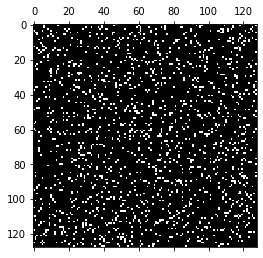

In [57]:
N = 128*128  # nodes/neurons
K = 100  # degree
# if activity=0.5, patterns are unbiased
activity = 0.1  # activity of the patterns/network 
np.random.seed(123)

# Pattern generation, random with p(xi=1)=a

P = 9  # random patterns to learn
ap = 0.1  # pattern activity
X = bernoulli.rvs(p=ap, size=(P, N))
plt.matshow(X[0].reshape(128,128), cmap='gray')
np.mean(X), np.shape(X)

activity: 0.1044921875


((10, 16384), 0.1044921875, 0.1044921875)

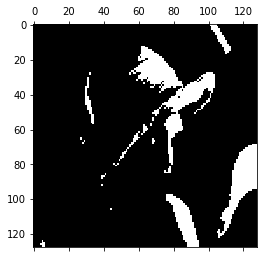

In [58]:
img = Image.open('./lenna.png')
img = img.resize((128,128), Image.ANTIALIAS)
imggs = img.convert('L')
th_value = 185
imgbw = np.asarray(imggs)
imgbw = (imgbw > th_value)*1
imgbw = imgbw
plt.matshow(imgbw, cmap='gray')
print('activity:', np.mean(imgbw))
lenna = imgbw.reshape(1, 128*128)
X = np.concatenate((X, lenna))
np.shape(X), np.mean(lenna), np.mean(X[-1])

In [95]:
def make_random(N, K):
    p = K/N
    C = []
    for i in range(N):
        C += np.where(np.insert(bernoulli.rvs(p, size=(N-1)), i, 0))
    C = np.array(C, dtype="int")
    return C

def make_ring(N, K):
    Ring = []
    for i in range(N):
        Ring += [[]]
        for k in range(K//2):
            Ring[i] += [i-(k+1), i+(k+1)]
    Ring = np.array(Ring)
    # Correct borders
    pos = np.where(Ring < 0)
    Ring[pos] = Ring[pos] + N
    pos = np.where(Ring >= N)
    Ring[pos] = Ring[pos] - N
    return Ring 

#C = make_ring(N, K)

C = []
for i in range(N):
    C += np.where(np.insert(bernoulli.rvs(K/N, size=(N-1)), i, 0))
C = np.array(C, dtype="object")

W = np.array([np.zeros(len(ci)) for ci in C], dtype="object")
C, W

(array([array([   80,   185,   220,   353,   664,   778,  1020,  1054,  1296,
                1378,  1421,  1982,  2173,  2190,  2233,  2274,  2380,  2468,
                2471,  2645,  2648,  2923,  2925,  3020,  3362,  3365,  3509,
                3975,  4094,  4384,  4722,  4830,  5114,  5344,  5381,  5441,
                5499,  5824,  5985,  6003,  6397,  6954,  7028,  7483,  7646,
                7748,  7756,  7789,  7822,  7835,  8212,  8219,  9176,  9218,
                9261,  9354,  9383,  9510,  9567,  9618,  9857, 10049, 10125,
               10174, 10176, 10182, 10514, 10923, 11151, 11355, 11454, 11502,
               11519, 11892, 12149, 12674, 12921, 13051, 13068, 13460, 13767,
               13776, 13779, 13941, 14004, 14170, 14308, 14406, 14584, 14659,
               14685, 15145, 15274, 15614, 15861])                           ,
        array([   67,   300,   631,   787,  1153,  1316,  1581,  1591,  1757,
                2135,  2245,  2336,  2509,  2688,  2739,  2867,

In [60]:
threshold = (1-2*ap)/(2*np.sqrt(ap*(1-ap)))

normalized_X = np.array([(x - np.mean(x))/np.sqrt(np.mean(x)*(1-np.mean(x))) for x in X])
np.shape(X), np.mean(normalized_X), np.std(normalized_X), threshold

((10, 16384), 1.3877787807814457e-17, 1.0, 1.3333333333333333)

In [97]:
# Weights initialization
W = np.array([np.zeros(len(ci)) for ci in C], dtype='object')

#for each pattern x in X
for x in normalized_X:
    # for each node i
    for i in range(N):
        W[i] = W[i] + x[C[i]]*x[i]

In [98]:
def normalize_vector(vector):
    av = np.mean(vector)
    return (vector - av)/np.sqrt(av*(1-av))

def act_threshold(neighbors, th):
    threshold = th
    if np.mean(neighbors) > 0.5:
        threshold = -th
    return threshold

(0.0, 1.0)

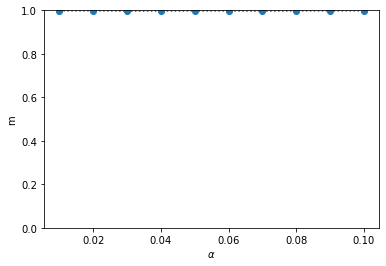

In [99]:
# Measure the quality of retrieval 
M = []  # M is 1, perfect retrieval, M is 0 no retrieval

#for each pattern x in X
for x in X:
    xt = np.copy(x)  # pattern x in time 0
    
    m = [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # initianl overlap in time 0, x is equal to xt, so m=1
    
    # update network for 100 steps
    for ti in range(100):
        # update each neuron xt[nxi]
        xt = np.array([(np.mean(normalize_vector(xt[C[nxi]])*W[nxi]) 
                        - act_threshold(xt[C[nxi]], threshold) >= 0)  # TH(local_field, threshod)
                       if np.var(xt[C[nxi]])  # if variance is not zero
                       else xt[nxi]  # state does not change otherwise
                       for nxi in range(N)])
        xt = xt.astype('int')
        m += [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # calculate overlap
        if m[-1] == m[-2]:
            break
    M += [m[-1]]
plt.plot(np.array(range(1,len(X)+1))/K, M, ':o')
plt.xlabel(r"$\alpha$")
plt.ylabel("m")
plt.ylim((0,1))

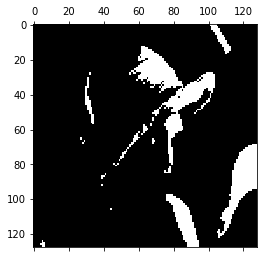

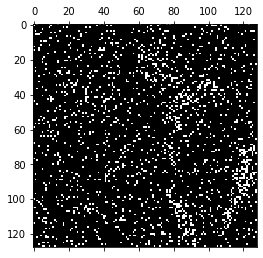

In [102]:
noise_level = 0.8

noisy_lenna = lenna.copy()

for i in range(np.shape(noisy_lenna)[1]):
    if np.random.random() < noise_level:
        noisy_lenna[0, i] = bernoulli.rvs(ap)

plt.matshow(X[-1].reshape((128,128)), cmap='gray')
plt.matshow(noisy_lenna.reshape((128,128)), cmap='gray')

0.00848388671875
0.029052734375
0.05865478515625
0.10382080078125


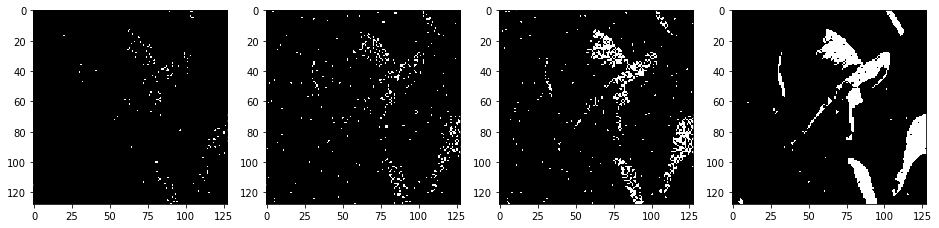

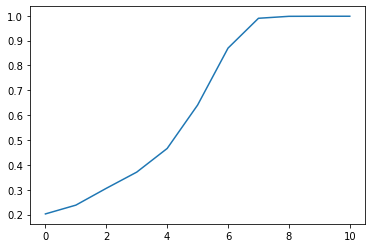

0.9980423948343137

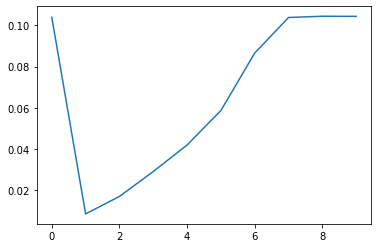

In [104]:
x = X[-1]  # Learned Lenna is in X, last pattern

xt = np.copy(noisy_lenna.flatten())  # init network in noisy lenna
        
m = [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # initial overlap

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,32))
ploti = 0

a_net = []

for ti in range(100):
    # network update for t=100
    a_net += [np.mean(xt)]
    # update each neuron xt[nxi]
    xt = np.array([(np.mean(normalize_vector(xt[C[nxi]])*W[nxi]) 
                    - act_threshold(xt[C[nxi]], threshold) >= 0)  # TH(local_field, threshod)
                   if np.var(xt[C[nxi]])  # if variance is not zero
                   else xt[nxi]  # state does not change otherwise
                   for nxi in range(N)])
    xt = xt.astype('int')
    m += [np.sum(normalize_vector(x)*normalize_vector(xt))/N]  # test overlap x and xt (net state)
    if not (ti % 2) and ploti < 4:
        print(np.mean(xt))
        ax[ploti].imshow(xt.reshape((128,128)), cmap=cmap)
        ploti += 1
    if m[-1] == m[-2]:
        break
plt.show()
plt.plot(m)
plt.show()
plt.plot(a_net)
m[-1]